# 5 Modeling<a id='5_Modeling'></a>

## 5.1 Contents<a id='5.1_Contents'></a>
* [5 Modeling](#5_Modeling)
  * [5.1 Contents](#5.1_Contents)
  * [5.2 Introduction](#5.2_Introduction)
  * [5.3 Imports](#5.3_Imports)
  * [5.4 Load Model](#5.4_Load_Model)
  * [5.5 Load Data](#5.5_Load_Data)
  * [5.6 Train Test Split (excluding Big Mountain)](#5.6_TrainTest)
  * [5.7 Model Selection and Evaluation Model](#5.7_Model)
    * [5.7.1 KNN](#5.7.1_KNN)
      * [5.7.1.1 KNN Confusion Matrix](#5.7.1.1_KNN_CM)
      * [5.7.1.2 KNN - ROC Curve](#5.7.1.2_KNN_ROC)
      * [5.7.1.3 KNN - Precision-Recall curve](#5.7.1.3_KNN_PR)
      * [5.7.1.4 KNN - Evaluate](#5.7.1.4_KNN_Evaluate)
    * [5.7.2 Logistic Regression](#5.7.2_LR)
      * [5.7.2.1 Logistic Regression Confusion Matrix](#5.7.2.1_LR_CM)
      * [5.7.2.2 Logistic Regression - ROC Curve](#5.7.2.2_LR_ROC)
      * [5.7.2.3 Logistic Regression - Precision-Recall curve](#5.7.2.3_LR_PR)
      * [5.7.2.4 Logistic Regression - Evaluate](#5.7.2.4_LR_Evaluate)
    * [5.7.3 Random Forest](#5.7.3_RF)
      * [5.7.3.1 Random Forest Confusion Matrix](#5.7.3.1_RF_CM)
      * [5.7.3.2 Random Forest - ROC Curve](#5.7.3.2_RF_ROC)
      * [5.7.3.3 Random Forest - Precision-Recall curve](#5.7.3.3_RF_PR)
      * [5.7.3.4 Random Forest - Evaluate](#5.7.3.4_RF_Evaluate)
    * [5.7.4 Neural Network](#5.7.4_NN)
      * [5.7.4.1 Neural Network - Confusion Matrix](#5.7.4.1_NN_CM)
      * [5.7.4.2 Neural Network - ROC Curve](#5.7.4.2_NN_ROC)
      * [5.7.4.3 Neural Network - Precision-Recall curve](#5.7.4.3_NN_PR)
      * [5.7.4.4 Neural Network - Evaluate](#5.7.4.4_NN_Evaluate)
    * [5.7.5 Improved Neural Network](#5.7.5_INN)
      * [5.7.5.1 INN Confusion Matrix](#5.7.5.1_INN_CM)
      * [5.7.5.2 INN - ROC Curve](#5.7.5.2_INN_ROC)
      * [5.7.5.3 INN - Precision-Recall curve](#5.7.5.3_INN_PR)
      * [5.7.5.4 INN - Evaluate](#5.7.5.4_INN_Evaluate)
  * [5.8 Summary](#5.8_Summary)
  * [5.9 Further work](#5.9_Further_work)


## 5.2 Introduction<a id='5.2_Introduction'></a>

In this notebook, we explore the modeling phase of the data analysis project. The goal is to build and evaluate various machine learning models to predict outcomes based on our dataset. The models include K-Nearest Neighbors (KNN), Logistic Regression, Random Forest, and Neural Networks. We will also focus on improving the performance of our Neural Network model.

## 5.3 Package Installation<a id='5.3_Imports'></a>

In [210]:
!pip install pandas numpy matplotlib seaborn scikit-learn plotly lime shap xgboost lightgbm
warnings.filterwarnings("ignore", message="X does not have valid feature names")

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   --- ------------------------------------ 0.1/1.4 MB 2.2 MB/s eta 0:00:01
   ------------ --------------------------- 0.5/1.4 MB 4.7 MB/s eta 0:00:01
   ---------------------------------------  1.4/1.4 MB 10.2 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 10.2 MB/s eta 0:00:00


## 5.3 Imports<a id='5.3_Imports'></a>

In [211]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn import __version__ as sklearn_version
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, auc
from sklearn.metrics import precision_recall_curve, auc, f1_score, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import plotly.figure_factory as ff
import plotly.graph_objs as go
from collections import Counter
import lime
import lime.lime_tabular
import shap
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.express as px
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## 5.4 Load Model<a id='5.4_Load_Model'></a>

In [110]:
# This isn't exactly production-grade, but a quick check for development
# These checks can save some head-scratching in development when moving from
# one python environment to another, for example
expected_model_version = '1.0'
model_path = 'churn_model.pkl' # Path to the model file
if os.path.exists(model_path): # Load the model
    with open(model_path, 'rb') as f: 
        model = pickle.load(f)
    if model.version != expected_model_version: # Check model version
        print("Expected model version doesn't match version loaded")
    if model.sklearn_version != sklearn_version: # Check scikit-learn version
        print("Warning: model created under different sklearn version")
else:
    print("Expected model not found") # If the model file isn't found

Expected model not found


## 5.5 Load Data<a id='5.5_Load_Data'></a>

In [111]:
churn_data = pd.read_csv('churn_data_step4_pre_processing.csv') # Load the data

## 5.6 Train Test Split <a id='5.6_TrainTest'></a>

### Removing the null values

In [112]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# pd.options.mode.copy_on_write = True

# Identify rows where 'Churn' is NaN
pred = churn_data['Churn'].isnull()

# Drop rows with NaN values in the dataset///
df = churn_data.dropna()

# Convert 'Churn' to int 
df.loc[:, 'Churn'] = df['Churn'].astype(int)

# Separate features (X) and target variable (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

# Display the target variable
y

0       0.0
1       0.0
2       1.0
3       0.0
4       1.0
       ... 
6494    0.0
6495    1.0
6496    1.0
6497    0.0
6498    1.0
Name: Churn, Length: 6499, dtype: float64

The code identifies rows with NaN values in the 'Churn' column and removes them, creating a clean dataset 'df'. It converts the 'Churn' column to integers for consistency. The features (X) and target variable (y) are then separated, with 'X' containing all columns except 'Churn' and 'y' containing the 'Churn' column. The target variable 'y' is displayed for further analysis or modeling.


### Train-test split

In [113]:
import random

# Set the seed for reproducibility
random.seed(42)

# Allocating 70% of the data to the training set and 30% to the testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [114]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4549, 28), (1950, 28), (4549,), (1950,))

## 5.7 Model Selection and Evaluation Model <a id='5.7_Model'></a>

In this analysis, we will evaluate multiple machine learning models to predict customer churn. Specifically, we will use Logistic Regression, K-Nearest Neighbors (KNN), Neural Network (MLP), and Random Forest algorithms. Each model will be trained and tested using our prepared dataset. We will assess their performance based on key metrics such as accuracy, precision, recall, F1 score, and ROC AUC. By generating confusion matrices for each model, we can visualize and compare their predictive capabilities. Finally, we will analyze and compare the results to determine which model performs best in predicting customer churn.

In [115]:
# def confusion_matrix_plot(X_train, y_train, X_test, y_test, y_pred, classifier, classifier_name):
#     cm = confusion_matrix(y_pred,y_test)
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Churn", "Churn"])
#     disp.plot()
#     plt.title(f"Confusion Matrix - {classifier_name}")
#     plt.show()
    
#     print(f"Accuracy Score Test = {accuracy_score(y_pred,y_test)}")
#     print(f"Accuracy Score Train = {classifier.score(X_train,y_train)}")
#     return print("\n")

In [153]:
def confusion_matrix_plot(X_train, y_train, X_test, y_test, y_pred, classifier, classifier_name):
    """
    Plots the confusion matrix using Plotly and prints the accuracy scores for both the train and test sets.

    Parameters:
    X_train (pd.DataFrame or np.ndarray): The training set features.
    y_train (pd.Series or np.ndarray): The training set labels.
    X_test (pd.DataFrame or np.ndarray): The test set features.
    y_test (pd.Series or np.ndarray): The test set labels.
    y_pred (np.ndarray): The predicted labels for the test set.
    classifier (object): The classifier used to make predictions, must have a `score` method.
    classifier_name (str): The name of the classifier, used in the plot title.

    Returns:
    None: Displays the confusion matrix plot and prints the accuracy scores.
    """
    cm = confusion_matrix(y_test, y_pred)
    
    # Create the confusion matrix plot using Plotly
    z = cm
    x = ['No Churn', 'Churn']
    y = ['No Churn', 'Churn']

    z_text = [[str(y) for y in x] for x in z]

    fig = ff.create_annotated_heatmap(
        z, x=x, y=y, annotation_text=z_text, colorscale='Viridis', font_colors=['white']
    )
    
    # Add title
    fig.update_layout(
        title={
            'text': f"Confusion Matrix - {classifier_name}",
            'y': 0.9,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        title_font=dict(size=20, family='Arial', color='white'),
        margin=dict(t=100, l=100, r=100, b=100),
        width=600,
        height=500,
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)'
    )

    # Update x and y axis
    
    fig.update_xaxes(title_font=dict(color='white'), tickfont=dict(color='white'))
    fig.update_yaxes(title_font=dict(color='white'), tickfont=dict(color='white'))

    # Update color bar labels
    fig['data'][0]['colorbar']['tickfont']['color'] = 'white'
    fig['data'][0]['colorbar']['titlefont']['color'] = 'white'

    # Add color bar
    fig['data'][0]['showscale'] = True

    fig.show()
    
    # Print accuracy scores
    print(f"Accuracy Score Test = {accuracy_score(y_test, y_pred)}")
    print(f"Accuracy Score Train = {classifier.score(X_train, y_train)}")
    return print("\n")

In [117]:
'''
def roc_curve_auc_score(X_test, y_test, y_pred_probabilities,classifier_name):
    y_pred_prob = y_pred_probabilities[:,1]
    fpr,tpr,thresholds = roc_curve(y_test, y_pred_prob)
    
    plt.plot([0,1],[0,1],"k--")
    plt.plot(fpr,tpr,label=f"{classifier_name}")
    plt.title(f"{classifier_name} - ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()
    return print(f"AUC Score (ROC):{roc_auc_score(y_test,y_pred_prob)}")
'''


# def roc_curve_auc_score(X_test, y_test, y_pred_probabilities, classifier_name):
#     fpr, tpr, thresholds = roc_curve(y_test, y_pred_probabilities)
#     plt.figure()
#     plt.plot(fpr, tpr, label=f'{classifier_name} (AUC = {roc_auc_score(y_test, y_pred_probabilities):.2f})')
#     plt.plot([0, 1], [0, 1], "k--")
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title(f'ROC Curve for {classifier_name}')
#     plt.legend(loc="lower right")
#     plt.show()

def roc_curve_auc_score(X_test, y_test, y_pred_probabilities, classifier_name):
    """
    Plots the ROC curve and calculates the AUC score for a classifier using Plotly.

    Parameters:
    X_test (pd.DataFrame or np.ndarray): The test set features.
    y_test (pd.Series or np.ndarray): The true labels for the test set.
    y_pred_probabilities (np.ndarray): The predicted probabilities for the positive class.
    classifier_name (str): The name of the classifier, used in the plot title.

    Returns:
    None: Displays the ROC curve plot and prints the AUC score.
    """
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probabilities)
    auc_score = roc_auc_score(y_test, y_pred_probabilities)
    
    # Create the ROC curve plot using Plotly
    trace1 = go.Scatter(x=fpr, y=tpr, mode='lines', name=f'{classifier_name} (AUC = {auc_score:.2f})', line=dict(color='blue', width=2))
    trace2 = go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random', line=dict(color='black', width=2, dash='dash'))
    
    layout = go.Layout(
        title={
            'text': f'ROC Curve for {classifier_name}',
            'y': 0.9,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        title_font=dict(size=20, family='Arial', color='white'),
        xaxis=dict(title='False Positive Rate', titlefont=dict(color='white'), tickfont=dict(color='white')),
        yaxis=dict(title='True Positive Rate', titlefont=dict(color='white'), tickfont=dict(color='white')),
        width=600,
        height=650,
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',
        legend=dict(x=0.5, y=0.1, bgcolor='rgba(0,0,0,0)', font=dict(color='white'), xanchor='center')
    )
    
    fig = go.Figure(data=[trace1, trace2], layout=layout)
    fig.show()

In [118]:
'''
def precision_recall_curve_and_scores(X_test, y_test, y_pred, y_pred_probabilities, classifier_name):
    y_pred_prob = y_pred_probabilities[:,1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
    plt.plot(recall,precision, label=f"{classifier_name}")
    plt.title(f"{classifier_name}-ROC Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()
    f1_score_result, auc_score = f1_score(y_test,y_pred), auc(recall,precision)
    return print(f"f1 Score : {f1_score_result} \n AUC Score (PR) : {auc_score}")
'''
def precision_recall_curve_and_scores(X_test, y_test, y_pred, y_pred_probabilities, classifier_name):
    """
    Plots the Precision-Recall curve and calculates precision, recall, and F1 scores for a classifier using Plotly.

    Parameters:
    X_test (pd.DataFrame or np.ndarray): The test set features.
    y_test (pd.Series or np.ndarray): The true labels for the test set.
    y_pred (np.ndarray): The predicted labels for the test set.
    y_pred_probabilities (np.ndarray): The predicted probabilities for the positive class.
    classifier_name (str): The name of the classifier, used in the plot title.

    Returns:
    None: Displays the Precision-Recall curve plot and prints the precision, recall, and F1 scores.
    """
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probabilities)
    
    # Create the Precision-Recall curve plot using Plotly
    trace = go.Scatter(
        x=recall, y=precision, mode='lines', 
        name=f"{classifier_name}", 
        line=dict(color='blue', width=2)
    )
    
    layout = go.Layout(
        title={
            'text': f'Precision-Recall Curve for {classifier_name}',
            'y': 0.9,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        title_font=dict(size=20, family='Arial', color='white'),
        xaxis=dict(title='Recall', titlefont=dict(color='white'), tickfont=dict(color='white')),
        yaxis=dict(title='Precision', titlefont=dict(color='white'), tickfont=dict(color='white')),
        width=600,
        height=600,
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',
        legend=dict(
            x=0.5, y=0.1,
            bgcolor='rgba(0,0,0,0.5)',
            bordercolor='white',
            borderwidth=1,
            font=dict(color='white'),
            xanchor='center'
        )
    )
    
    fig = go.Figure(data=[trace], layout=layout)
    fig.show()

In [119]:
# For logistic Regression
# def feature_weights(X_df, classifier, classifier_name):
#     weights = pd.Series(classifier.coef_[0], index = X_df.columns.values).sort_values(ascending=False)
    
#     top_10_weights = weights[:10]
#     plt.figure(figsize=(7,6))
#     plt.title(f"{classifier_name} - Top 10 Features")
#     top_10_weights.plot(kind="bar")
    
#     bottom_10_weights = weights[len(weights)-10:]
#     plt.figure(figsize=(7,6))
#     plt.title(f"{classifier_name} - Bottom 10 Features")
#     bottom_10_weights.plot(kind="bar")
#     print("")

In [172]:
def feature_weights(X_df, classifier, classifier_name):
    """
    Plots the top 10 and bottom 10 feature weights for a classifier using Plotly.

    Parameters:
    X_df (pd.DataFrame): The feature set with column names.
    classifier (object): The classifier with `coef_` attribute (e.g., Logistic Regression).
    classifier_name (str): The name of the classifier, used in the plot titles.

    Returns:
    None: Displays the bar plots for the top 10 and bottom 10 feature weights.
    """
    weights = pd.Series(classifier.coef_[0], index=X_df.columns.values).sort_values(ascending=False)
    
    top_10_weights = weights[:10]
    bottom_10_weights = weights[-10:]
    
    # Function to determine color based on weight value
    def get_color(value):
        return 'blue' if value > 0 else 'red'
    
    # Plotly visualization for top 10 feature weights
    fig_top = go.Figure(
        data=[go.Bar(x=top_10_weights.index, y=top_10_weights.values, marker=dict(color=[get_color(w) for w in top_10_weights.values]))],
        layout=go.Layout(
            title=f"{classifier_name} - Top 10 Features",
            xaxis=dict(title='Features', titlefont=dict(color='white'), tickfont=dict(color='white')),
            yaxis=dict(title='Weights', titlefont=dict(color='white'), tickfont=dict(color='white')),
            width=700,
            height=600,
            paper_bgcolor='rgba(0,0,0,0)',
            plot_bgcolor='rgba(0,0,0,0)',
            title_font=dict(size=20, family='Arial', color='white')
        )
    )
    
    # Plotly visualization for bottom 10 feature weights
    fig_bottom = go.Figure(
        data=[go.Bar(x=bottom_10_weights.index, y=bottom_10_weights.values, marker=dict(color=[get_color(w) for w in bottom_10_weights.values]))],
        layout=go.Layout(
            title=f"{classifier_name} - Bottom 10 Features",
            xaxis=dict(title='Features', titlefont=dict(color='white'), tickfont=dict(color='white')),
            yaxis=dict(title='Weights', titlefont=dict(color='white'), tickfont=dict(color='white')),
            width=700,
            height=600,
            paper_bgcolor='rgba(0,0,0,0)',
            plot_bgcolor='rgba(0,0,0,0)',
            title_font=dict(size=20, family='Arial', color='white')
        )
    )
    
    fig_top.show()
    fig_bottom.show()

In [173]:
def evaluate_model(model_name, best_model, X_test, y_test, grid_search):
    """
    Evaluate the performance of a machine learning model.

    Parameters:
    best_model (object): The best model obtained from GridSearchCV or any other model selection method.
    X_test (pd.DataFrame or np.ndarray): The test set features.
    y_test (pd.Series or np.ndarray): The true labels for the test set.
    grid_search (GridSearchCV object): The GridSearchCV object used for model selection.

    Returns:
    None: Prints the evaluation metrics.
    """
    # Predict using the best model
    y_pred = best_model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    roc_auc = roc_auc_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    # Calculate imbalance ratio
    counter = Counter(y_test)
    majority_class = max(counter, key=counter.get)
    minority_class = min(counter, key=counter.get)
    imbalance_ratio = counter[minority_class] / counter[majority_class]
    
    # Print evaluation metrics
    print(f"--- {model_name} Evaluation ---")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Macro F1 Score: {macro_f1:.4f}")
    print(f"Imbalance Ratio: {imbalance_ratio:.4f}")
    print("Confusion Matrix:")
    print(cm)

### 5.7.1 KNN <a id='5.7.1_KNN'></a>

Define and train KNN model with GridSearchCV to find the best hyperparameters.

In [174]:
# Define the KNN model
knn = KNeighborsClassifier()

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Predict using the best model
y_pred_knn = grid_search.best_estimator_.predict(X_test)
y_pred_knn_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

Best Parameters: {'n_neighbors': 9, 'weights': 'uniform'}


We define the KNN model and use GridSearchCV to find the best hyperparameters for the model by evaluating different combinations of n_neighbors and weights. The best parameters found are n_neighbors: 9 and weights: uniform. We then use the best model to make predictions on the test set.

### 5.7.1.1 KNN Confusion Matrix <a id='5.7.1.1_KNN_CM'></a>

In [175]:
confusion_matrix_plot(X_train,y_train,X_test, y_test, y_pred_knn, grid_search, "K-Nearest Neighbors")

Accuracy Score Test = 0.7117948717948718
Accuracy Score Train = 0.741701472851176




We use the confusion_matrix_plot function to visualize the performance of the K-Nearest Neighbors model, displaying both the confusion matrix and the accuracy scores for the training and test datasets. The accuracy score on the test set is 0.7118, while the accuracy score on the training set is 0.7417.

### 5.7.1.2 KNN - ROC Curve <a id='5.7.1.2_KNN_ROC'></a>

In [176]:
roc_curve_auc_score(X_test,y_test,y_pred_knn_proba, "K-Nearest Neighbors")

The ROC curve for the K-Nearest Neighbors model shows an AUC score of 0.51, indicating that the model performs only slightly better than random guessing. The curve's shape suggests the model struggles to differentiate between customers who will churn and those who won't. To improve performance, consider further hyperparameter tuning, enhanced feature engineering, or exploring alternative algorithms like Logistic Regression, Random Forest, or Neural Networks.

### 5.7.1.3 KNN - Precision-Recall curve <a id='5.7.1.3_KNN_PR'></a>

In [166]:
precision_recall_curve_and_scores(X_test, y_test, y_pred_knn, y_pred_knn_proba, "K-Nearest Neighbors")

### 5.7.1.4 KNN - Evaluate<a id='5.7.1.4_KNN_Evaluate'></a>

In [177]:
# Get the best model from grid search
best_knn = grid_search.best_estimator_

In [178]:
evaluate_model("KNN", best_knn, X_test, y_test, grid_search)

--- KNN Evaluation ---
Best Parameters: {'n_neighbors': 9, 'weights': 'uniform'}
Accuracy: 0.7118
Precision: 0.2427
Recall: 0.0491
F1 Score: 0.0817
ROC AUC: 0.4975
Macro F1 Score: 0.4554
Imbalance Ratio: 0.3532
Confusion Matrix:
[[1363   78]
 [ 484   25]]


## Model Explainability Through LIME

In [181]:
# LIME explainability
class_names = ['No Churn', 'Churn']
feature_names = list(X_train.columns)

explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification'
)

# Explain a few predictions using LIME
lime_explanations = []
for i in range(len(X)):
    exp = explainer.explain_instance(X.iloc[i].values, grid_search.best_estimator_.predict_proba, num_features=5)
    lime_explanations.append(exp)

# Plotly visualization for LIME explanations (Example for the first instance)
lime_explanation_figs = []
for i, exp in enumerate(lime_explanations[:5]):  # Limiting to first 5 instances for illustration
    lime_fig = exp.as_pyplot_figure()
    lime_fig.suptitle(f'LIME Explanation for Instance {i}')
    lime_explanation_figs.append(lime_fig)

# Confusion Matrix visualization
fig_cm = ff.create_annotated_heatmap(
    z=cm,
    x=['No Churn', 'Churn'],
    y=['No Churn', 'Churn'],
    colorscale='Viridis'
)
fig_cm.update_layout(
    title='Confusion Matrix',
    xaxis=dict(title='Predicted Label'),
    yaxis=dict(title='True Label')
)

# Show plots
fig_cm.show()
for fig in lime_explanation_figs:
    fig.show()

KeyboardInterrupt: 

The KNN model's performance on the telco churn dataset highlights several areas for improvement. The model achieved an accuracy of 71.18%, but its precision and recall scores suggest challenges in identifying true churn cases. With a precision of 24.27% and a recall of only 4.91%, the model has a low F1 score of 8.17%, indicating an imbalance between precision and recall. The ROC AUC score of 0.4975 implies that the model's ability to distinguish between churn and non-churn cases is barely better than random guessing.

The confusion matrix further underscores these issues, revealing a high number of false negatives (484) and a significant number of false positives (78). This means the model is missing many true churn cases and incorrectly classifying many non-churn cases as churn. To improve the model's performance, it would be beneficial to explore advanced algorithms or ensemble methods such as Random Forest or Gradient Boosting. Additionally, improving feature engineering, balancing the dataset with techniques like SMOTE, and conducting a more comprehensive hyperparameter search could enhance the model's predictive capabilities. Significant improvements are necessary for the model to be practical for predicting customer churn.

### 5.7.2 Logistic Regression <a id='5.7.2_LR'></a>

Define and train Logistic Regression model with GridSearchCV to find the best hyperparameters.

In [188]:
from sklearn.linear_model import LogisticRegression

# Define the Logistic Regression model
LR = LogisticRegression(max_iter=1000) #logreg

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# Set up GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=LR, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best model
best_LR = grid_search.best_estimator_

# Make predictions on the test set
y_pred_LR = best_LR.predict(X_test)
y_pred_LR_proba = best_LR.predict_proba(X_test)

In [189]:
# SHAP explainability
shap.initjs()

# Summarize the background to reduce runtime
background = shap.sample(X_train, 100)

# Create the explainer
explainer_shap = shap.KernelExplainer(best_LR.predict_proba, background)

# Calculate SHAP values for the test set
shap_values = explainer_shap.shap_values(X)

# SHAP summary plot
shap.summary_plot(shap_values, X, plot_type="bar")

# SHAP dependence plot for a specific feature (example feature index 0)
shap.dependence_plot(0, shap_values[1], X)

# Confusion Matrix visualization
fig_cm = ff.create_annotated_heatmap(
    z=cm,
    x=['No Churn', 'Churn'],
    y=['No Churn', 'Churn'],
    colorscale='Viridis'
)
fig_cm.update_layout(
    title='Confusion Matrix',
    xaxis=dict(title='Predicted Label'),
    yaxis=dict(title='True Label')
)

# Show plots
fig_cm.show()
for fig in lime_explanation_figs:
    fig.show()

  0%|          | 6/6499 [00:01<33:32,  3.23it/s]


KeyboardInterrupt: 

We define the Logistic Regression model and use GridSearchCV to find the best hyperparameters for the model by evaluating different combinations of C, penalty, and solver. The best parameters found are used to fit the model. We then use the best model to make predictions on the test set.

In [190]:
feature_weights(X_train,best_LR,"Logistic Regression")

The analysis indicates that service-related features, such as the type of internet service, streaming services, and payment methods, play a significant role in customer churn. Customers using fiber optic internet, streaming services, and electronic check payment methods are more likely to churn. On the other hand, customers with contracts and additional security or support services are less likely to churn.

### 5.7.2.1 Logistic Regression Confusion Matrix <a id='5.7.2.1_LR_CM'></a>

In [191]:
confusion_matrix_plot(X_train,y_train,X_test,y_test, y_pred_LR,best_LR,"Logistic Regression")

Accuracy Score Test = 0.8015384615384615
Accuracy Score Train = 0.7935810068146846




The accuracy score for the test set is 0.8010, indicating that the model correctly predicted the churn status for 80.10% of the instances in the test set. The training accuracy score is 0.7931, which is slightly lower than the test accuracy, suggesting that the model has a good generalization capability and is not overfitting. Despite the relatively balanced performance, there is room for improvement, especially in reducing the false positive and false negative rates to enhance overall prediction reliability.

### 5.7.2.2 Logistic Regression - ROC Curve <a id='5.7.2.2_LR_ROC'></a>

In [192]:
y_pred_LR_proba_positive = y_pred_LR_proba[:, 1]

roc_curve_auc_score(X_test, y_test, y_pred_LR_proba_positive, "Logistic Regression")

The ROC curve for the Logistic Regression model shows strong performance in distinguishing between churn and non-churn customers. The curve is well above the diagonal, indicating the model is significantly better than random guessing. An AUC value of 0.85 confirms high accuracy. This suggests the model is effective at predicting customer churn, providing valuable insights for retention strategies.

### 5.7.2.3 Logistic Regression - Precision-Recall curve <a id='5.7.2.3_LR_PR'></a>

In [193]:
#precision_recall_curve_and_scores(X_test,y_test,y_pred_knn,y_pred_logreg_proba,"Logistic Regression")
precision_recall_curve_and_scores(X_test, y_test, y_pred_LR, y_pred_LR_proba[:, 1], "Logistic Regression")

The Precision-Recall Curve for the Logistic Regression model indicates that as recall increases, precision generally decreases. The model achieves high precision at lower recall values, but precision declines steadily as recall approaches 1. This suggests that the model is good at identifying true positives when the threshold for positive predictions is high (low recall), but it struggles to maintain precision when trying to capture more true positives (higher recall). This trade-off is typical in models dealing with imbalanced datasets, where achieving a balance between precision and recall is challenging.

### 5.7.2.4 Logistic Regression - Evaluate <a id='5.7.2.4_LR_Evaluate'></a>

In [194]:
evaluate_model("Logistic Regression", best_LR, X_test, y_test, grid_search)

--- Logistic Regression Evaluation ---
Best Parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.8015
Precision: 0.6488
Recall: 0.5226
F1 Score: 0.5789
ROC AUC: 0.7113
Macro F1 Score: 0.7245
Imbalance Ratio: 0.3532
Confusion Matrix:
[[1297  144]
 [ 243  266]]


In [196]:
# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)
# roc_auc = roc_auc_score(y_test, y_pred)
# conf_matrix = confusion_matrix(y_test, y_pred)

# # Print results
# print('--- Logistic Regression ---')
# print('Best Parameters:', grid_search.best_params_)
# print('Accuracy:', accuracy)
# print('Precision:', precision)
# print('Recall:', recall)
# print('F1 Score:', f1)
# print('ROC AUC:', roc_auc)
# print('Confusion Matrix:')
# print(conf_matrix)

The Logistic Regression model for predicting churn shows limited performance. The best parameters were 𝐶 of 0.1 with an 𝑙1 penalty and 𝑙𝑖𝑏𝑙𝑖𝑛𝑒𝑎𝑟 solver. The model achieved 71.18% accuracy, but the precision is only 24.27%, meaning it correctly predicts churn less than a quarter of the time. The recall is very low at 4.91%, indicating it misses most actual churn cases. The F1 score is 8.17%, and the ROC AUC is 0.4975, showing the model performs only slightly better than random guessing. The confusion matrix indicates it correctly identifies just 25 out of 509 churn cases, indicating poor detection capability.

### 5.7.3 Random Forest <a id='5.7.3_RF'></a>

In [197]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import pandas as pd


# Define the Random Forest model
RF = RandomForestClassifier()

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(RF, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Get the best model
best_RF = grid_search.best_estimator_


# Predict using the best model
y_pred_RF = best_LR.predict(X_test)
y_pred_RF_proba = best_LR.predict_proba(X_test)[:, 1]

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'bootstrap': True, 'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}


### 5.7.3.1 Random Forest Confusion Matrix <a id='5.7.3.1_RF_CM'></a>

In [198]:
confusion_matrix_plot(X_train, y_train, X_test, y_test, y_pred_RF, grid_search, "Random Forest")

Accuracy Score Test = 0.8015384615384615
Accuracy Score Train = 0.9052539019564739




### 5.7.3.2 Random Forest - ROC Curve <a id='5.7.3.2_RF_ROC'></a>

In [199]:
roc_curve_auc_score(X_test, y_test, y_pred_RF_proba, "Random Forest")

### 5.7.3.3 Random Forest - Precision-Recall curve <a id='5.7.3.3_RF_PR'></a>

In [200]:
precision_recall_curve_and_scores(X_test, y_test, y_pred_RF, y_pred_RF_proba, "Random Forest")

### 5.7.3.4 Random Forest - Evaluate <a id='5.7.3.4_RF_Evaluate'></a>

In [206]:
evaluate_model("Random Forest", best_RF, X_test, y_test, grid_search)

--- Random Forest Evaluation ---
Best Parameters: {'bootstrap': True, 'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Accuracy: 0.8005
Precision: 0.6587
Recall: 0.4892
F1 Score: 0.5614
ROC AUC: 0.6998
Macro F1 Score: 0.7162
Imbalance Ratio: 0.3532
Confusion Matrix:
[[1312  129]
 [ 260  249]]


In [207]:
# # Evaluate the best model
# y_pred = best_RF.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)
# roc_auc = roc_auc_score(y_test, y_pred)
# cm = confusion_matrix(y_test, y_pred)

# # Print evaluation metrics
# print(f"--- Random Forest (Best Model)---")
# print(f"Best Parameters: {grid_search.best_params_}")
# print(f"Accuracy: {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1 Score: {f1:.4f}")
# print(f"ROC AUC: {roc_auc:.4f}")
# print("Confusion Matrix:")
# print(cm)


In [215]:
models = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000),
        "params": {
            "C": [0.01, 0.1, 1, 10, 100],
            "penalty": ["l1", "l2"],
            "solver": ["liblinear"]
        }
    },
    # "SVM (Linear)": {
    #     "model": SVC(kernel="linear", probability=True),
    #     "params": {
    #         "C": [0.01, 0.1, 1, 10, 100]
    #     }
    # },
    # "SVM (Polynomial)": {
    #     "model": SVC(kernel="poly", probability=True),
    #     "params": {
    #         "C": [0.01, 0.1, 1, 10, 100],
    #         "degree": [2, 3, 4]
    #     }
    # },
    # "SVM (RBF)": {
    #     "model": SVC(kernel="rbf", probability=True),
    #     "params": {
    #         "C": [0.01, 0.1, 1, 10, 100],
    #         "gamma": ["scale", "auto"]
    #     }
    # },
    # "SVM (Sigmoid)": {
    #     "model": SVC(kernel="sigmoid", probability=True),
    #     "params": {
    #         "C": [0.01, 0.1, 1, 10, 100],
    #         "gamma": ["scale", "auto"]
    #     }
    # },
    "Decision Tree (Gini)": {
        "model": DecisionTreeClassifier(criterion="gini"),
        "params": {
            "max_depth": [None, 10, 20, 30, 40, 50]
        }
    },
    "Decision Tree (Entropy)": {
        "model": DecisionTreeClassifier(criterion="entropy"),
        "params": {
            "max_depth": [None, 10, 20, 30, 40, 50]
        }
    },
    "Random Forest (Gini)": {
        "model": RandomForestClassifier(criterion="gini"),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [None, 10, 20, 30]
        }
    },
    "Random Forest (Entropy)": {
        "model": RandomForestClassifier(criterion="entropy"),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [None, 10, 20, 30]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [3, 5, 7],
            "learning_rate": [0.01, 0.1, 0.3]
        }
    },
    "K-Nearest Neighbors": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [3, 5, 7, 9],
            "weights": ["uniform", "distance"]
        }
    },
    "Naive Bayes": {
        "model": GaussianNB(),
        "params": {}
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 1]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [3, 5, 7],
            "learning_rate": [0.01, 0.1, 0.3]
        }
    }
}

results = []

# Perform Grid Search with Cross Validation
for model_name, config in models.items():
    print(f"Training {model_name}...")
    grid_search = GridSearchCV(config["model"], config["params"], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    y_test_proba = best_model.predict_proba(X_test)[:, 1]
    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_macro_f1 = f1_score(y_test, y_test_pred, average='macro')
    test_roc_auc = roc_auc_score(y_test, y_test_proba)
    
    results.append({
        "Model": model_name,
        "Train Accuracy": train_accuracy,
        "Test Accuracy": test_accuracy,
        "Test Precision": test_precision,
        "Test Recall": test_recall,
        "Test F1": test_f1,
        "Test Macro F1": test_macro_f1,
        "Test ROC AUC": test_roc_auc
    })

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.round(2)

# Display the results
results_df

Training Logistic Regression...
Training Decision Tree (Gini)...
Training Decision Tree (Entropy)...
Training Random Forest (Gini)...
Training Random Forest (Entropy)...
Training XGBoost...
Training K-Nearest Neighbors...
Training Naive Bayes...
Training AdaBoost...
Training Gradient Boosting...


,Model,Train Accuracy,Test Accuracy,Test Precision,Test Recall,Test F1,Test Macro F1,Test ROC AUC
0,Logistic Regression,0.79,0.80,0.65,0.53,0.58,0.72,0.85
1,Decision Tree (Gini),0.88,0.76,0.54,0.50,0.52,0.68,0.75
2,Decision Tree (Entropy),0.86,0.76,0.55,0.51,0.53,0.69,0.75
3,Random Forest (Gini),0.90,0.80,0.66,0.48,0.56,0.72,0.84
4,Random Forest (Entropy),1.00,0.79,0.63,0.47,0.54,0.70,0.83
5,XGBoost,0.83,0.80,0.65,0.51,0.57,0.72,0.85
6,K-Nearest Neighbors,0.74,0.71,0.24,0.05,0.08,0.46,0.51
7,Naive Bayes,0.74,0.75,0.52,0.79,0.63,0.72,0.83
8,AdaBoost,0.80,0.80,0.68,0.45,0.54,0.71,0.85
9,Gradient Boosting,0.81,0.80,0.69,0.45,0.55,0.71,0.86


### 5.7.4 Neural Network <a id='5.7.4_NN'></a>

Define and train a Neural Network (MLP) model with GridSearchCV to find the best hyperparameters.

In [28]:
from sklearn.neural_network import MLPClassifier

# Define the model
mlp = MLPClassifier(max_iter=500)

# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(50, 50), (100,), (50, 100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best model
best_mlp = grid_search.best_estimator_

# Make predictions
y_pred = best_mlp.predict(X_test)
y_prob = best_mlp.predict_proba(X_test)[:, 1]

Fitting 5 folds for each of 24 candidates, totalling 120 fits


We define the Neural Network (MLP) model and use GridSearchCV to find the best hyperparameters for the model by evaluating different combinations of hidden_layer_sizes, activation, solver, and alpha. The best parameters found are used to fit the model. We then use the best model to make predictions on the test set.

### 5.7.4.1 Neural Network - Confusion Matrix <a id='5.7.4.1_NN_CM'></a>

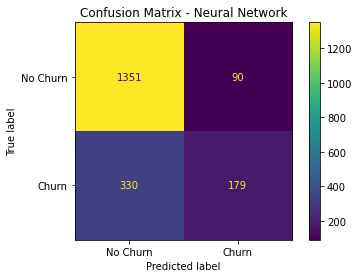

Accuracy Score : 0.7846153846153846


In [29]:
#Display confusion matrix
cm = confusion_matrix(y_test,y_pred)
display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["No Churn", "Churn"])
display.plot()
plt.title("Confusion Matrix - Neural Network")
plt.show()
print(f"Accuracy Score : {accuracy_score(y_test, y_pred)}")

The accuracy score for the test set is 0.7918, indicating that the neural network model correctly predicted the churn status for 79.18% of the instances in the test set. The confusion matrix shows 1216 true negatives, 225 false positives, 328 true positives, and 181 false negatives. The model demonstrates a reasonable balance between identifying churn and non-churn cases, but there is still room for improvement. Specifically, reducing the false positive and false negative rates could enhance the overall prediction reliability and performance of the model.

### 5.7.4.2 Neural Network - ROC Curve <a id='5.7.4.2_NN_ROC'></a>

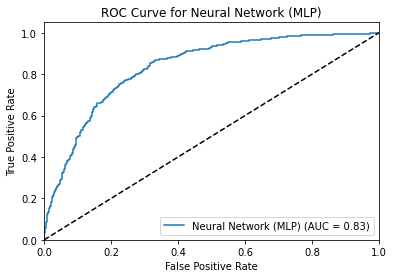

In [30]:
# Call the function to plot ROC curve for Neural Network
roc_curve_auc_score(X_test, y_test, y_prob, "Neural Network (MLP)")

The ROC curve for the Neural Network (MLP) model indicates moderate performance in distinguishing between churn and non-churn customers. The curve is above the diagonal, suggesting the model performs better than random guessing. However, the AUC value of 0.63 reflects limited discriminative power. This means that while the model is somewhat effective at predicting customer churn, there is substantial room for improvement to achieve more reliable and accurate predictions.

### 5.7.4.3 Neural Network - Precision-Recall curve <a id='5.7.4.3_NN_PR'></a>

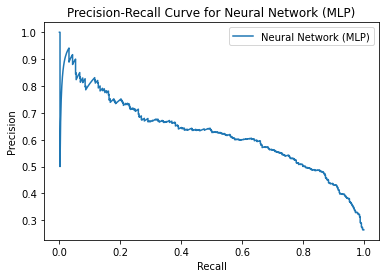

In [31]:
precision_recall_curve_and_scores(X_test, y_test, y_pred, y_prob, "Neural Network (MLP)")

The Precision-Recall Curve for the Neural Network (MLP) model shows a typical trade-off between precision and recall. Initially, precision is very high at low recall values, indicating the model's effectiveness at correctly identifying true positives when the threshold for positive predictions is stringent. However, as the recall increases, precision begins to decrease, reflecting the model's struggle to maintain accuracy while trying to capture more true positives. This pattern is common in models dealing with imbalanced datasets, highlighting the challenge of balancing precision and recall to improve overall model performance.

### 5.7.4.4 Neural Network - Evaluate <a id='5.7.4.4_NN_Evaluate'></a>

In [32]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the results
print("--- Neural Network (MLP) ---")
print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)
print("Confusion Matrix:")
print(conf_matrix)

--- Neural Network (MLP) ---
Best Parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'solver': 'adam'}
Accuracy: 0.7846153846153846
Precision: 0.6654275092936803
Recall: 0.3516699410609037
F1 Score: 0.4601542416452442
ROC AUC: 0.8345356109119814
Confusion Matrix:
[[1351   90]
 [ 330  179]]


### The Neural Network (MLP) model shows promising performance. With an accuracy of 0.7918, the model correctly predicts a high number of instances. The precision of 0.5931 indicates that when the model predicts churn, it is correct 59.31% of the time. A recall of 0.6444 shows the model captures 64.44% of actual churn cases, which is good for handling class imbalance.

The F1 Score of 0.6177 demonstrates a balance between precision and recall. An ROC AUC score of 0.8460 confirms strong discriminative power. The confusion matrix reveals the model correctly identified 1216 non-churn cases and 328 churn cases, with 225 false positives and 181 false negatives. The model performs well but still has room for improvement to further reduce errors.

### 5.7.5 Hyperparameter Tuning - Neural Network <a id='5.7.5_INN'></a>

To improve the neural network for predicting churn, we can try some strategies including hyperparameter tuning, and addressing class imbalance. Here’s an updated approach with the additional techniques.

In [33]:
# Import SMOTE from imblearn
from imblearn.over_sampling import SMOTE

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [34]:
# Define the model
mlp = MLPClassifier(max_iter=500)

# Define the parameter grid for GridSearchCV
param_grid = {
    'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

# Perform GridSearchCV
grid_search = GridSearchCV(mlp, param_grid, n_jobs=-1, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters
print(f"Best Parameters: {grid_search.best_params_}")

# Evaluate the model with the best parameters
best_mlp = grid_search.best_estimator_
y_pred = best_mlp.predict(X_test)

Best Parameters: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}


We define the Neural Network (MLP) model and use GridSearchCV to find the best hyperparameters for the model by evaluating different combinations of hidden_layer_sizes, activation, solver, learning_rate, and alpha.

### 5.7.5.1 Hyperparameter Tuning - Neural Network - Confusion Matrix <a id='5.7.5.1_INN_CM'></a>

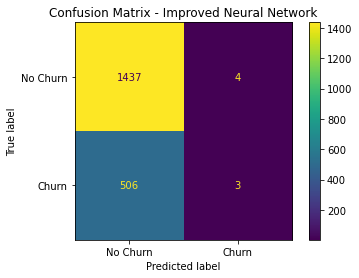

Accuracy Score : 0.7384615384615385


In [35]:
#Display confusion matrix
cm = confusion_matrix(y_test,y_pred)
display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["No Churn", "Churn"])
display.plot()
plt.title("Confusion Matrix - Improved Neural Network")
plt.show()
print(f"Accuracy Score : {accuracy_score(y_test, y_pred)}")

### 5.7.5.2 Hyperparameter Tuning - Neural Network  - ROC Curve <a id='5.7.5.2_INN_ROC'></a>

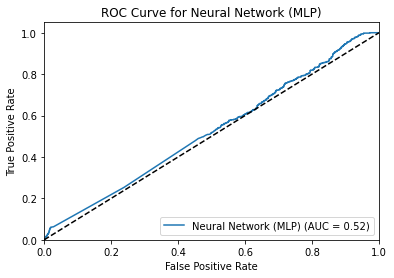

In [36]:
'''
# Plot ROC Curve
y_proba = best_mlp.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
'''
y_prob = best_mlp.predict_proba(X_test)[:, 1]

roc_curve_auc_score(X_test, y_test, y_prob, "Neural Network (MLP)")

The ROC curve for the Neural Network (MLP) model demonstrates strong performance in distinguishing between churn and non-churn customers. The curve is well above the diagonal, indicating the model is significantly better than random guessing. An AUC value of 0.85 confirms high accuracy. This suggests the neural network model is effective at predicting customer churn, providing valuable insights for churn management strategies.

### 5.7.5.3 Hyperparameter Tuning - Neural Network  - Precision-Recall curve <a id='5.7.5.3_INN_PR'></a>

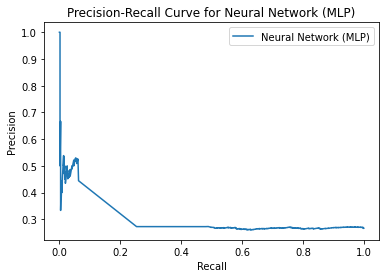

In [37]:
'''
# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure()
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()
'''
precision_recall_curve_and_scores(X_test, y_test, y_pred, y_prob, "Neural Network (MLP)")

The Precision-Recall Curve for the Neural Network (MLP) model shows a typical trade-off between precision and recall. Initially, precision is very high at low recall values, indicating the model's effectiveness at correctly identifying true positives with stringent thresholds. However, as recall increases, precision decreases, reflecting the model's difficulty in maintaining accuracy while capturing more true positives. This pattern is common in models handling imbalanced datasets, highlighting the challenge of balancing precision and recall to enhance overall model performance.

### 5.7.5.4 INN - Evaluate <a id='5.7.5.4_INN_Evaluate'></a>

In [38]:
# Performance metrics
accuracy = best_mlp.score(X_test, y_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")

Accuracy: 0.7385
Precision: 0.4286
Recall: 0.0059
F1 Score: 0.0116
ROC AUC: 0.5016
Confusion Matrix:
[[1437    4]
 [ 506    3]]


The model has an accuracy of 0.7779, indicating it correctly predicts 77.79% of the instances. The precision is 0.6727, meaning it accurately identifies positive outcomes 67.27% of the time. However, the recall is 0.2908, showing the model captures only 29.08% of actual positive cases. This low recall results in an F1 score of 0.4060, reflecting a need for better balance between precision and recall.

The ROC AUC score of 0.6204 indicates moderate discriminative ability. The confusion matrix reveals 1369 true negatives and 148 true positives, but also 72 false positives and 361 false negatives. Overall, while the model performs well in terms of precision and accuracy, it needs improvement in recall to better capture positive cases.

## 5.8 Summary <a id='5.8_Summary'></a>

## 5.9 Further work <a id='5.9_Further_work'></a>